# MNIST Handwritten Digit Classification with Custom Neural Network

THIS NOTEBOOK IS STILL IN DEVELOPMENT! The final version will be released in due course.

In [1]:
# import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from NeuralNetwork import NeuralNetwork
from NetworkConfigHandler import NetworkConfigHandler
from PreProcessor import PreProcessor
from DataHandler import DataHandler
from ActivationFunctions import ActivationFunctions

In [2]:
mnist_train = '../data/mnist_data/mnist_train.csv'
mnist_test = '../data/mnist_data/mnist_test.csv'

In [3]:
# get datasets
delimiter = ','
features = [f'pixel_{i}' for i in range(784)]
targets = ['id']
column_names = targets + features

In [4]:
train_df = PreProcessor.load_data(mnist_train, column_names=column_names)
test_df = PreProcessor.load_data(mnist_test, column_names=column_names)

Reading data from ../data/mnist_data/mnist_train.csv
Reading data from ../data/mnist_data/mnist_test.csv


In [5]:
train_df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create train-validation split

In [7]:
test_df, val_df = PreProcessor.split_dataset(test_df, 0.2, seed=42)
test_df.shape, val_df.shape

((8000, 785), (2000, 785))

In [8]:
X_train = PreProcessor.normalize_dataset(train_df.loc[:, features].to_numpy())
y_train = train_df.loc[:, targets].to_numpy()

X_val = PreProcessor.normalize_dataset(val_df.loc[:, features].to_numpy())
y_val = val_df.loc[:, targets].to_numpy()

X_test = PreProcessor.normalize_dataset(test_df.loc[:, features].to_numpy())
y_test = test_df.loc[:, targets].to_numpy()

### Encode targets

In [9]:
encoder = OneHotEncoder(sparse=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))

y_val_one_hot = encoder.transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_train.reshape(-1, 1))

In [10]:
y_train[0], y_train_one_hot[0], y_train_one_hot.shape

(array([5]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), (60000, 10))

In [11]:
def plot_digit(digit, label=None):
    plt.imshow(digit.reshape(28, 28), cmap='gray')
    if label != None:
        plt.title(f'Digit: {label}')
    plt.show()

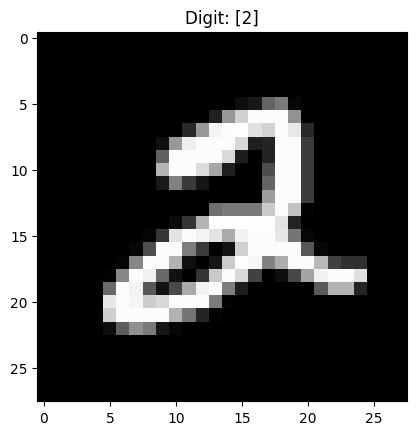

In [12]:
idx = 5
plot_digit(X_train[idx], y_train[idx])

### Create Input Data Pipeline with DataHandler

In [13]:
train_ds = DataHandler(X_train, y_train_one_hot)
val_ds = DataHandler(X_val, y_val_one_hot)
test_ds = DataHandler(X_test, y_test_one_hot)

# Build Neural Network

In [26]:
# initialise neural network parameters
n = len(features)
layer_config = [n, 512, 64, 10]
activation_functions = ["leaky_ReLU", "leaky_ReLU", "tanh"]
alpha = 0.01
# activation_function = "leaky_ReLU"
const_c = 0.01

In [48]:
model_config = [
    {'units': n, 'activation': 'relu'},
    {'units': 512, 'activation': 'relu'},
    {'units': 64, 'activation': 'relu'},
    {'units': 10, 'activation': 'tanh'}
]

In [47]:
# construct neural network
model = NeuralNetwork(model_config, alpha)

In [49]:
x_t, y_t = train_ds[idx]
x_t, y_t = x_t.reshape(-1, 1), y_t.reshape(-1, 1)
x_t.shape, y_t.shape

((784, 1), (10, 1))

In [50]:
y_pred = model(x_t)
y_pred

array([[-0.70239726],
       [-0.1511292 ],
       [-0.0596279 ],
       [-0.19453381],
       [-0.6079578 ],
       [-0.09770418],
       [-0.5426682 ],
       [-0.39780867],
       [-0.61999437],
       [-0.69498394]])

In [51]:
model.back_propagate_error(y_t)

In [52]:
model.update_network()

In [53]:
#train neural network
epochs = 2
model.fit(train_ds, val_ds, epochs)
# NN.evaluate(X_test, y_test)

Data received -> Training initiated...
Epoch 1/2


100%|██████████| 60000/60000 [04:03<00:00, 246.04it/s]


cost: 20.306488			val_cost: 20.279075
accuracy: 0.0993		val_accuracy: 0.099
-------------------------------------------------
Epoch 2/2


 36%|███▋      | 21881/60000 [01:28<02:34, 246.82it/s]


KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds)

In [ ]:
preds = model.get_predictions(test_ds)

In [ ]:
preds[1]